In [93]:
# Basics Importation 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

# For Detailed Stats Output
import statsmodels.api as sm
# The linear regression models 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoCV, ElasticNetCV
# Instantiating the linear regression models
ols = LinearRegression()
ridge = Ridge()
lasso  = Lasso()
lassocv = LassoCV()
elasticnet = ElasticNet()
elasticnetcv = ElasticNetCV()
# The tree model
from sklearn import tree
# Instantiating the tree model (regression type)
regressor = tree.DecisionTreeRegressor()
# The ensemble model for random forest and bagging
from sklearn import ensemble
# Instantiating the ensemble models
randomForest = ensemble.RandomForestRegressor()
bagging = ensemble.BaggingRegressor()
# Instantiating the boost models
gbm = ensemble.GradientBoostingRegressor()
abr = ensemble.AdaBoostRegressor()
# xg boost
import xgboost as xgb
# lg boost
import lightgbm as lgb
# K mean clustering
from sklearn.cluster import KMeans
kmeans = KMeans()
# The model selection for cross validation, k fold splits, train_test_split, grid search etc. 
import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
# Some automatic feature selection functions (recursive finding, best feature selection etc.)
import sklearn.feature_selection as fs
# Importing the different error evaluation/metrics
from sklearn import metrics
from sklearn.metrics import silhouette_score
# Importing PCA
from sklearn.decomposition import PCA
# Making it so that we can see all columns of the dataframe
pd.set_option('display.max_columns', None)

# Import data
df=pd.read_csv('purged_dummified_clustered_df.csv', index_col='Id')
df_test=pd.read_csv('purged_dummified_clustered_df_test.csv', index_col='Id')
x=df[~df.SalePrice.isnull()].drop(['SalePrice'],axis=1)
y=df[~df.SalePrice.isnull()].SalePrice
x_test=df_test
# df_test must have (1459) rows

In [94]:
def undummify(dataframe):
    tot_col=dataframe.columns
    cat_col=list(tot_col[tot_col.str.contains('__')])
    cat_col_split=set(map(lambda x:x.split('__')[0],cat_col))
    cat_dict={}
    for col in cat_col_split:
        sub_df=dataframe[cat_col].loc[:,list(map(lambda x:col in x, dataframe[cat_col].columns))]
        for i in sub_df.columns:
            label_num=int(i.split('__')[1])
            sub_df.loc[:,i]=np.array(sub_df.loc[:,i])*label_num
        cat_dict[col]=sub_df.sum(axis=1)+1
    df1=dataframe.drop(cat_col,axis=1)
    df2=pd.DataFrame(cat_dict)
    return pd.concat([df1,df2],axis=1)

In [95]:
def important_coefs_lasso(model, dataframe,returnlist):
    '''
    - A function that returns non-zero coefficients in order from a lasso model output
    ---------------
    - dataframe: dataframe of model inputs
    - model: model object
    '''
    lassoCoef = pd.Series(model.coef_, index=dataframe.columns)
    if returnlist=='Pos': 
        lassoCoef=lassoCoef[np.abs(lassoCoef)>0]
        return lassoCoef.sort_values(ascending=False)
    elif returnlist=='Zero':
        lassoCoef=lassoCoef[np.abs(lassoCoef)<=1e-5]
        return lassoCoef.sort_values(ascending=False)
    else: 
        return lassoCoef.sort_values(ascending=False)

In [96]:
def sort_ridge_coefs(model, dataframe):
    ridge_coef = pd.Series(model.coef_, index=dataframe.columns)
    ridge_coef.sort_values(ascending=False)
    order = abs(ridge_coef).sort_values(ascending=False)
    return ridge_coef[order.index]

In [104]:
trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.3, random_state=0)

### Lasso

In [106]:
# Initial Lasso
trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.3, random_state=0)
alphaRange = np.linspace(10e-6,0.05,100)
grid_param=[{'alpha': alphaRange}]
para_search = GridSearchCV(estimator=Lasso(max_iter=5000),param_grid=grid_param, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
para_search.fit(trainX, trainY)
lasso_best_score = para_search.best_score_
lasso_best_alpha = para_search.best_params_['alpha']
lasso.set_params(alpha=lasso_best_alpha, normalize = False)
lasso.fit(trainX,trainY)

l_MSE = np.mean((lasso.predict(testX)-testY)**2)
l_RMSE_in_dollars = np.mean((np.exp(lasso.predict(testX))-np.exp(testY))**2)**0.5
print('Test MSE: %s' %(l_MSE))
print('Test RMSE in $$: %s' %(l_RMSE_in_dollars))

p1=lasso.predict(x_test)

/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9545054787292808, tolerance: 0.006701146776314116
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.807652753640395, tolerance: 0.0071506886974076
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.844354700116652, tolerance: 0.0067133381719157855
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to

Test MSE: 0.016394434225211772
Test RMSE in $$: 17219.48350843465


In [181]:
lasso_worst_feat.index

Index(['OverallQual.1', 'MSSubClass__9', 'MoSold__1', 'MSSubClass__8',
       'GarageType__5', 'MSSubClass__11', 'Exterior2nd__7', 'LotShape__1',
       'MoSold__3', 'MoSold__7',
       ...
       'SaleType__2', 'Condition2__2', 'Condition2__4', 'MasVnrType__1',
       'GarageType__3', 'MSSubClass__12', 'Neighborhood__20', 'Exterior2nd__5',
       'Heating__3', 'Fence__4'],
      dtype='object', length=105)

In [190]:
# Remove Worst Features for Lasso right away
lasso_worst_feat=important_coefs_lasso(lasso, trainX,'Zero')
lasso_df=trainX.copy()
lasso_df_test=testX.copy()
lasso_df.drop(lasso_worst_feat.index,axis=1,inplace=True)

x_test.drop(lasso_worst_feat.index,axis=1,inplace=True)

lasso_df_test.drop(lasso_worst_feat.index,axis=1,inplace=True)
l_para_search=GridSearchCV(estimator=Lasso(max_iter=5000,tol=0.007),param_grid=grid_param, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
l_para_search.fit(lasso_df,trainY)
l_lasso_score=-l_para_search.score(lasso_df,trainY)
l_lasso_test_score=-l_para_search.score(lasso_df_test,testY)
l_RMSE_in_dollars=np.mean((np.exp(-l_para_search.predict(lasso_df_test))-np.exp(testY))**2)**0.5
print('train MSE: %s' %(l_lasso_score))
print('test MSE: %s' %(l_lasso_test_score))
print('Test RMSE in $$: %s' %(l_RMSE_in_dollars))

p2=l_para_search.predict(x_test)

train MSE: 0.008930797277710735
test MSE: 0.017902545525812778
Test RMSE in $$: 166332.10683328725


In [107]:
# lasso_best_feat=important_coefs_lasso(lasso, trainX,'All')
# lasso_best_feat=abs(lasso_best_feat)
# lasso_best_feat=lasso_best_feat.sort_values(ascending=False)
# lasso_best_feat=list(lasso_best_feat.index)

In [150]:
# # Recursive Lasso
# recursive_lasso_score=[]
# recursive_lasso_test_score=[]
# i=0
# lasso_df=trainX.copy()
# lasso_df_test=testX.copy()
# for col in lasso_best_feat[-1:-101:-1]:
#     i+=1
#     lasso_df.drop(col,axis=1,inplace=True)
#     lasso_df_test.drop(col,axis=1,inplace=True)
#     recursive_para_search=GridSearchCV(estimator=Lasso(max_iter=5000,tol=0.007),param_grid=grid_param, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
#     recursive_para_search.fit(lasso_df,trainY)
#     recursive_lasso_score.append(recursive_para_search.score(lasso_df,trainY))
#     recursive_lasso_test_score.append(recursive_para_search.score(lasso_df_test,testY))
#     print(i,'/',np.array(lasso_best_feat[-1:-101:-1]).shape[0],end='\r')

/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9833742636017875, tolerance: 0.4690802743419881
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8054111056944788, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9237112820449218, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to in

/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9818364656587719, tolerance: 0.4690802743419881
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6723281688594045, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9222932183202075, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to in

/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.981507854232043, tolerance: 0.4690802743419881
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9367834683523266, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3288708446605353, tolerance: 0.4896749821817048
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to in

/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9820562485278286, tolerance: 0.4690802743419881
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9380089157862905, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3561813223452721, tolerance: 0.4896749821817048
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to i

/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9821003415793133, tolerance: 0.4690802743419881
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5921343192615764, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8803759694749631, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to in

/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2007408091668708, tolerance: 0.4690802743419881
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5938070562171007, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0391610373611293, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to in

/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8971771785516771, tolerance: 0.4690802743419881
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7252904976581096, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.366544097785508, tolerance: 0.4896749821817048
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to in

/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8909902035866928, tolerance: 0.4690802743419881
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7292694149824985, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3587985137595946, tolerance: 0.4896749821817048
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to i

/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8474242965047392, tolerance: 0.4690802743419881
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8895937732445058, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.345403245631674, tolerance: 0.4896749821817048
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to in

/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8475022150350151, tolerance: 0.4690802743419881
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9058980443171094, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.345312681036839, tolerance: 0.4896749821817048
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to in

/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8519418340205749, tolerance: 0.4690802743419881
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9079318144521609, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4483855872097966, tolerance: 0.48699292573887715
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0041899726701637, tolerance: 0.4690802743419881
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7627517772538384, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1709941125066985, tolerance: 0.48699292573887715
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.004449576058892, tolerance: 0.4690802743419881
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8366572161448633, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.098693461941951, tolerance: 0.48699292573887715
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.007147485119747, tolerance: 0.4690802743419881
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5497251277957815, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1899500884631502, tolerance: 0.48699292573887715
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.032905704675044, tolerance: 0.4690802743419881
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5518421552748087, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3678629754536948, tolerance: 0.4896749821817048
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to in

/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9985392271752835, tolerance: 0.4690802743419881
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5463219359483515, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.368192479036369, tolerance: 0.4896749821817048
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to in

/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9174163743489863, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3170222103481086, tolerance: 0.4896749821817048
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0980812030168834, tolerance: 0.48699292573887715
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9149010932674699, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3168886237337762, tolerance: 0.4896749821817048
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.097088905974372, tolerance: 0.48699292573887715
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8652723669418481, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.335710124291974, tolerance: 0.4896749821817048
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0950096534083877, tolerance: 0.48699292573887715
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6104549214090897, tolerance: 0.4690802743419881
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9185582234026084, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.350243217404554, tolerance: 0.4896749821817048
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to in

/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6103664959537305, tolerance: 0.4690802743419881
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9185566913538934, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3502382905129513, tolerance: 0.4896749821817048
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to i

/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6440216521197679, tolerance: 0.4690802743419881
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9382869955563495, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2659928128664701, tolerance: 0.4896749821817048
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to i

/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7287338593534547, tolerance: 0.4690802743419881
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.690710150685792, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8552713955850122, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to inc

/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6819212832663717, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8020762316090932, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2008716367009369, tolerance: 0.4896749821817048
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to in

/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5840299233997266, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.221879499034795, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2066667058725866, tolerance: 0.4896749821817048
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to inc

/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5864355591754311, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2122196507372702, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2068583482360051, tolerance: 0.4896749821817048
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to in

/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5864686686369569, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2487916634089145, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2068561929797197, tolerance: 0.4896749821817048
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to in

/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.586542047621005, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2484741571770324, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2023531184644907, tolerance: 0.4896749821817048
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to inc

/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5957554572717259, tolerance: 0.4690802743419881
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.586864320736808, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.28260232356068, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to incre

/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5972148013082514, tolerance: 0.4690802743419881
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5868708069940594, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2822815066462079, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to in

/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5932589196452813, tolerance: 0.4690802743419881
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5869507155432641, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2833802921314912, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to in

/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.586983777156096, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.897011165300255, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4072376558367719, tolerance: 0.4896749821817048
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to incr

/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5871086273887118, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8197101377627214, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3877813018319094, tolerance: 0.4896749821817048
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to in

/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5870784870084287, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4341022004746353, tolerance: 0.4896749821817048
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5163053274323213, tolerance: 0.48699292573887715
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5870879090798353, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.507653681553635, tolerance: 0.4896749821817048
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5346969423126762, tolerance: 0.48699292573887715
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5871203961979647, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5371546027116736, tolerance: 0.4896749821817048
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5449700946448521, tolerance: 0.48699292573887715
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5897629342691895, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5313971425240656, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1321142411214689, tolerance: 0.4896749821817048
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to in

/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5901002298428359, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5556303706648849, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9556552077254472, tolerance: 0.4896749821817048
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5971322943537563, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.318158801013751, tolerance: 0.4896749821817048
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5974330324087229, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3040420277937619, tolerance: 0.4896749821817048
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.597435811460735, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3324473713787581, tolerance: 0.4896749821817048
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5975421056811805, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5985806537150715, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7091954306896766, tolerance: 0.4896749821817048
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5977982083498814, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5999748527024176, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6733655005123067, tolerance: 0.4896749821817048
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5977976484681031, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5999686914706972, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6741005390035331, tolerance: 0.4896749821817048
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5977665092000484, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5975761291498798, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6490746568054631, tolerance: 0.4896749821817048
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6497211841583348, tolerance: 0.4896749821817048
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6497214808779832, tolerance: 0.4896749821817048
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5994799477256985, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5975430798951908, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6501669701068646, tolerance: 0.4896749821817048
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5994677012487064, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5981278822614278, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6501668617604133, tolerance: 0.4896749821817048
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5986512892087283, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6501845796897197, tolerance: 0.4896749821817048
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6001270587808492, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6070685001953255, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6505423479342074, tolerance: 0.4896749821817048
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6007676349740918, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.607457033013699, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6507362519062294, tolerance: 0.4896749821817048
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6038308471566456, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.653076459447032, tolerance: 0.4896749821817048
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6042158129427331, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6531770423506078, tolerance: 0.4896749821817048
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6043672935832305, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6537135516422041, tolerance: 0.4896749821817048
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6042862105577518, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.653902794051846, tolerance: 0.4896749821817048
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6065581280860117, tolerance: 0.46993367203410497
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6557533922171834, tolerance: 0.4896749821817048
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6500092607083388, tolerance: 0.4896749821817048
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6165304013147721, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6593136544627329, tolerance: 0.4896749821817048
  positive)


/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6165233467561122, tolerance: 0.500548208818532
  positive)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6593064003104172, tolerance: 0.4896749821817048
  positive)


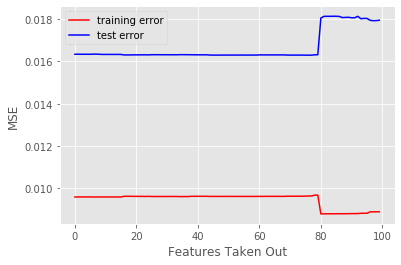

In [153]:
# plt.figure()
# plt.plot(np.array(recursive_lasso_score)*-1,c='red', label='training error')
# plt.plot(np.array(recursive_lasso_test_score)*-1,c='blue', label='test error')
# plt.ylabel('MSE')
# plt.xlabel('Features Taken Out')
# plt.legend()
# plt.show()

### Ridge

In [191]:
# Initial Ridge
trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.3, random_state=0)
r_alphaRange = np.linspace(10e-3,100,100)
r_grid_param=[{'alpha': r_alphaRange}]
r_para_search = GridSearchCV(estimator=Ridge(max_iter=5000),param_grid=r_grid_param, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
r_para_search.fit(trainX, trainY)

ridge_best_score = r_para_search.best_score_
ridge_best_alpha = r_para_search.best_params_['alpha']
ridge.set_params(alpha=ridge_best_alpha, normalize = False)
ridge.fit(trainX,trainY)

r_MSE = np.mean((ridge.predict(testX)-testY)**2)
r_RMSE_in_dollars = np.mean((np.exp(ridge.predict(testX))-np.exp(testY))**2)**0.5
print('Test MSE: %s' %(r_MSE))
print('Test RMSE in $$: %s' %(r_RMSE_in_dollars))

Test MSE: 0.016399932716881775
Test RMSE in $$: 17116.949142031106


In [192]:
ridge_best_feat=sort_ridge_coefs(ridge, trainX).index
# Recursive ridge
recursive_ridge_score=[]
recursive_ridge_test_score=[]
i=0
ridge_df=trainX.copy()
ridge_df_test=testX.copy()
for col in ridge_best_feat[-1:-101:-1]:
    i+=1
    ridge_df.drop(col,axis=1,inplace=True)
    ridge_df_test.drop(col,axis=1,inplace=True)
    recursive_r_para_search=GridSearchCV(estimator=Ridge(max_iter=5000),param_grid=grid_param, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
    recursive_r_para_search.fit(ridge_df,trainY)
    recursive_ridge_score.append(recursive_r_para_search.score(ridge_df,trainY))
    recursive_ridge_test_score.append(recursive_r_para_search.score(ridge_df_test,testY))
    print(i,'/',np.array(ridge_best_feat[-1:-101:-1]).shape[0],end='\r')

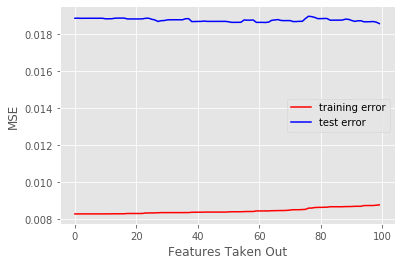

In [193]:
plt.figure()
plt.plot(np.array(recursive_ridge_score)*-1,c='red', label='training error')
plt.plot(np.array(recursive_ridge_test_score)*-1,c='blue', label='test error')
plt.ylabel('MSE')
plt.xlabel('Features Taken Out')
plt.legend()
plt.show()

In [158]:
### Random Forest

In [161]:
# Initial Ridge
param_grid = {
    'max_depth' : range(5,20),\
    'max_features': range(5,20)
}
randomForest = ensemble.RandomForestRegressor()
grid_search_forest = GridSearchCV(ensemble.RandomForestRegressor(n_estimators=100,criterion="mse",\
                                                                 min_samples_leaf=2,min_samples_split=2,\
                                                                 bootstrap=True,oob_score = True,n_jobs=-1),\
                                  param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1,refit=True)
%time grid_search_forest.fit(trainX, trainY)

# Print results    
print('MSE Score on test data set (using best parameters): {0:.3f}'.format(-grid_search_forest.score(testX, testY)))
print('RMSE in $$ on test data set (using best parameters): {0:.1f}'.format(\
      np.mean((np.exp(grid_search_forest.predict(testX))-np.exp(testY))**2)**0.5))

CPU times: user 8.06 s, sys: 394 ms, total: 8.46 s
Wall time: 1min 17s
MSE Score on test data set (using best parameters): 0.023
RMSE in $$ on test data set (using best parameters): 18027.0


In [212]:
randomForest.set_params(n_estimators=100,criterion="mse",bootstrap=True,oob_score = False,n_jobs=-1,random_state=0,\
                       max_depth=grid_search_forest.best_params_['max_depth'],max_features=grid_search_forest.best_params_['max_features'])
randomForest.fit(trainX,trainY)
forest_best_feat=pd.Series(randomForest.feature_importances_,index=trainX.columns)
forest_best_feat.sort_values(ascending=False,inplace=True)
forest_best_feat=list(forest_best_feat.index)

In [213]:
# Recursive forest
recursive_forest_score=[]
recursive_forest_test_score=[]
i=0
forest_df=trainX.copy()
forest_df_test=testX.copy()
for reduction in range(7):
    i+=1
    removelist=forest_best_feat[-30:-1]
    for item in removelist:
        forest_best_feat.remove(item)
    forest_df.drop(removelist,axis=1,inplace=True)
    forest_df_test.drop(removelist,axis=1,inplace=True)
    recursive_f_para_search=GridSearchCV(ensemble.RandomForestRegressor(n_estimators=100,criterion="mse",\
                                                                 min_samples_leaf=2,min_samples_split=2,\
                                                                 bootstrap=True,oob_score = True,n_jobs=-1),\
                                  param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1,refit=True)
    recursive_f_para_search.fit(forest_df,trainY)
    recursive_forest_score.append(recursive_f_para_search.score(forest_df,trainY))
    recursive_forest_test_score.append(recursive_f_para_search.score(forest_df_test,testY))
    print(i,'/',np.array(forest_best_feat).shape[0],end='\r')

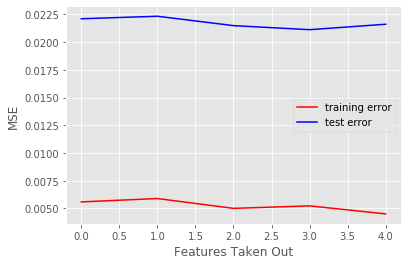

In [217]:
plt.figure()
plt.plot(np.array(recursive_forest_score)*-1,c='red', label='training error')
plt.plot(np.array(recursive_forest_test_score)*-1,c='blue', label='test error')
plt.ylabel('MSE')
plt.xlabel('Features Taken Out')
plt.legend()
plt.show()

In [171]:
# # Recursive forest
# recursive_forest_score=[]
# recursive_forest_test_score=[]
# i=0
# forest_df=trainX.copy()
# forest_df_test=testX.copy()
# for col in forest_best_feat[-1:-101:-1]:
#     i+=1
#     forest_df.drop(col,axis=1,inplace=True)
#     forest_df_test.drop(col,axis=1,inplace=True)
#     recursive_f_para_search=GridSearchCV(ensemble.RandomForestRegressor(n_estimators=100,criterion="mse",\
#                                                                  min_samples_leaf=2,min_samples_split=2,\
#                                                                  bootstrap=True,oob_score = True,n_jobs=-1),\
#                                   param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1,refit=True)
#     recursive_f_para_search.fit(forest_df,trainY)
#     recursive_forest_score.append(recursive_f_para_search.score(forest_df,trainY))
#     recursive_forest_test_score.append(recursive_f_para_search.score(forest_df_test,testY))
#     print(i,'/',np.array(forest_best_feat[-1:-101:-1]).shape[0],end='\r')

KeyboardInterrupt: 